# Modeling Supervised Learning - LSTM (top 30)

In this section the supervised learning is presented.

## Loading libraries and dataset

In [24]:
# Libraries to load
from google.colab import drive

# For preprocessing
import numpy as np
import pandas as pd 
import re
import string # for string operations
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')   # download the stopwords from NLTK

# For ML
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.callbacks import EarlyStopping

# For plotting
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
rawdf = pd.read_csv('/content/drive/My Drive/VIU/TFM/2nd Iteration/quotes_phase0.csv', error_bad_lines=False, header=0)

In [27]:
# Make a copy to avoud reloads
df = rawdf.copy(deep=True)

In [28]:
df.shape

(367185, 2)

In [29]:
df.head()

,Quotes,Label
0,"I'm selfish, impatient and a little insecure. ...","attributed-no-source, best, life, love, mistak..."
1,You've gotta dance like there's nobody watchin...,"dance, heaven, hurt, inspirational, life, love..."
2,You know you're in love when you can't fall as...,"attributed-no-source, dreams, love, reality, s..."
3,A friend is someone who knows all about you an...,"friend, friendship, knowledge, love"
4,Darkness cannot drive out darkness: only light...,"darkness, drive-out, hate, inspirational, ligh..."


In [30]:
df.Label.isna().sum()

0

## Preprocesing quotes (without stemming)

The first thing that needs to be done is to preprocess the data. This includes:

* Cleansome short words, lower case and remove non-alphabetic characters
* Removing Stop Words
* Tokenize
* Detokenize

In [31]:
#We do it with this one step
df.Label = df.Label.apply(lambda x: x.replace(',',''))
df.Label = df.Label.apply(lambda x: x.lower())

**Clean**

In this section the short words, the none-alphabetic words and the lowercases are eliminated.

In [32]:
# removing everything except alphabets`
df['clean_doc'] = df['Quotes'].str.replace("[^a-zA-Z#]", " ")

# removing short words
df['clean_doc'] = df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
df['clean_doc'] = df['clean_doc'].apply(lambda x: x.lower())

In [33]:
df.head(5)

,Quotes,Label,clean_doc
0,"I'm selfish, impatient and a little insecure. ...",attributed-no-source best life love mistakes o...,selfish impatient little insecure make mistake...
1,You've gotta dance like there's nobody watchin...,dance heaven hurt inspirational life love sing,gotta dance like there nobody watching love li...
2,You know you're in love when you can't fall as...,attributed-no-source dreams love reality sleep,know love when fall asleep because reality fin...
3,A friend is someone who knows all about you an...,friend friendship knowledge love,friend someone knows about still loves
4,Darkness cannot drive out darkness: only light...,darkness drive-out hate inspirational light lo...,darkness cannot drive darkness only light that...


**Tokenizing**

In this section all documents (quotes) from the documents_list are being tokenized and added to a new list called tokenized_docs.

In [34]:
# tokenization
tokenized_doc = df.clean_doc.apply(lambda x: x.split())

**Removing Stop Words & detokenizing**

In this step, each doc in the list tokenized_docs will be parsed and each stopword eliminated. A new list stopped_docs with the clean docs will be created.

In [35]:
#Import the english stop words list from NLTK
stopwords_english = stopwords.words('english')

additional_words = ['people', 'like', 'love', 'never', 'life']

stopwords_total = stopwords_english + additional_words

print('Stop words\n')
print(stopwords_english)

print('\nPunctuation\n')
print(string.punctuation)

Stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [36]:
# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stopwords_total])

# de-tokenization
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df['clean_doc'] = detokenized_doc

In [37]:
df.head(3)

,Quotes,Label,clean_doc
0,"I'm selfish, impatient and a little insecure. ...",attributed-no-source best life love mistakes o...,selfish impatient little insecure make mistake...
1,You've gotta dance like there's nobody watchin...,dance heaven hurt inspirational life love sing,gotta dance nobody watching hurt sing nobody l...
2,You know you're in love when you can't fall as...,attributed-no-source dreams love reality sleep,know fall asleep reality finally better dreams


## Reducing amount of labels



In previous work not shown here, it has been observed that there were too many labels in the dataset. This made impossible to get proper predictions because the number of features (different labels) was around 100k (almost 30% of the inputs).

For this reason it was decided to pick up the top 30 labels (in term of usage and emotion reflection).

Top 15 labels + top 15 emotions

In [38]:
labelskept = ['love', 'life', 'inspirational','humor', 'philosophy', 'god', 'truth','romance',
              'death','success','wisdom',
              'grief', 'faith', 'good', 'work',
              'happiness', 'hope', 'funny', 'fear', 
              'passion', 'imagination', 'motivational', 'compassion', 'freedom',
              'purpose', 'leadership', 'courage', 'peace', 'pain',
              'creativity']

test = pd.DataFrame(labelskept,columns=['labelskept'])
len(test.labelskept.unique())

30

In [39]:
#tokanizing label column
tokenized_doc = df.Label.apply(lambda x: x.split())
print(tokenized_doc)

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item in labelskept])
print(tokenized_doc)

# de-tokenization
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df.Label = detokenized_doc

0         [attributed-no-source, best, life, love, mista...
1         [dance, heaven, hurt, inspirational, life, lov...
2         [attributed-no-source, dreams, love, reality, ...
3                     [friend, friendship, knowledge, love]
4         [darkness, drive-out, hate, inspirational, lig...
                                ...                        
367180                             [christian, will, exist]
367181                                [past, believe, help]
367182                               [team, humility, know]
367183                            [life, my, life, servant]
367184                              [god, promises, bright]
Name: Label, Length: 367185, dtype: object
0                  [life, love, truth]
1          [inspirational, life, love]
2                               [love]
3                               [love]
4         [inspirational, love, peace]
                      ...             
367180                              []
367181                  

In [40]:
df.head()

,Quotes,Label,clean_doc
0,"I'm selfish, impatient and a little insecure. ...",life love truth,selfish impatient little insecure make mistake...
1,You've gotta dance like there's nobody watchin...,inspirational life love,gotta dance nobody watching hurt sing nobody l...
2,You know you're in love when you can't fall as...,love,know fall asleep reality finally better dreams
3,A friend is someone who knows all about you an...,love,friend someone knows still loves
4,Darkness cannot drive out darkness: only light...,inspirational love peace,darkness cannot drive darkness light hate cann...


In [41]:
df.shape

(367185, 3)

In [42]:
#Eliminate all rows without values
df.Label = df.Label.replace('',np.nan, regex=True)
df = df.dropna()

Another problem lived during the development of the final master work, was the scarcity in documentation on how to apporach a multilabel data mining problem with neural networks. 

This fact together with my inexperience forced me to recued the dataset to rows where register had just one label.

In [43]:
#Let's check if its still multilabel
df['Label Count'] = 3
for ind, row in df.iterrows():
  df['Label Count'][ind] = len(row['Label'].split())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [44]:
#Sort quotes to see longest ones
sortquotes = df.sort_values(['Label Count'], ascending=False)
sortquotes.head(7)

,Quotes,Label,clean_doc,Label Count
193751,"Life depends on, how much you're alive",death hope inspirational life love romance truth,depends much alive,7
8374,We never realize just how many other lives we ...,happiness inspirational life love philosophy t...,realize many lives help paths cross,7
82148,The best don't start at the top; embrace every...,faith happiness inspirational life love motiva...,best start embrace every struggle mistake obst...,7
8608,The statement ‘There is nothing more American ...,humor inspirational life love philosophy truth...,statement nothing american indian happens mult...,7
70994,"God is working on your behalf, for your happin...",faith god happiness life love peace success,working behalf happiness inner peace move forw...,7
88075,Look beyond what you think is possible for you...,creativity freedom happiness imagination life ...,look beyond think possible stretch imagination...,7
14613,"Happiness keeps you Sweet , Trials keep you St...",faith happiness inspirational life love motiva...,happiness keeps sweet trials keep strong sorro...,7


As it can be seen, there are still many multi-labeled registers.

In [45]:
df.shape

(128068, 4)

In [48]:
# Here we just keep the registers with one label.
df = df[df['Label Count'] == 1]

In [49]:
df.shape

(93395, 4)

## LSTM Modelling

### Vectorization
Let's vectorize the quotes into vectors with a limit of 50.000 words.

In [50]:
# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 50000


# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['clean_doc'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 45443 unique tokens.


Let's truncate and pad the inputs to have same length for modelling.

In [99]:
X = tokenizer.texts_to_sequences(df['clean_doc'].values)
X = pad_sequences(X, maxlen=30)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (93395, 30)


In [100]:
print(X[3])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  578  578  411   75
 1024 4045]


Convert categorical labels into numbers

In [101]:
Y = pd.get_dummies(df['Label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (93395, 30)


In [102]:
temporal = pd.get_dummies(df['Label'])

In [103]:
temporal.columns

Index(['compassion', 'courage', 'creativity', 'death', 'faith', 'fear',
       'freedom', 'funny', 'god', 'good', 'grief', 'happiness', 'hope',
       'humor', 'imagination', 'inspirational', 'leadership', 'life', 'love',
       'motivational', 'pain', 'passion', 'peace', 'philosophy', 'purpose',
       'romance', 'success', 'truth', 'wisdom', 'work'],
      dtype='object')

### Dataset split
Let's split the datasets:

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(84055, 30) (84055, 30)
(9340, 30) (9340, 30)


### Defining the shape of the nueral network

* The first layer is the embedded layer that uses 100 length vectors to represent each word.

* SpatialDropout1D performs variational dropout in NLP models (increases drops).

* The next layer is the LSTM layer with 100 memory units.

* The output layer must create 13 output values, one for each class.

* Activation function is softmax for multi-class classification.

* Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

* Many more parameters were tested but here I am just presenting the final result.


In [105]:
model = Sequential()

# Configuring the parameters
model.add(Embedding(MAX_NB_WORDS, output_dim=20, input_length=X.shape[1]))

# Adding a dropout layer
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))

# Adding a dense output layer with softmax activation
model.add(Dense(30, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 20)            1000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 30, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               48400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
Total params: 1,051,430
Trainable params: 1,051,430
Non-trainable params: 0
_________________________________________________________________


In [106]:
history = model.fit(X_train, Y_train,
                    epochs=5,
                    batch_size=528,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
144/144 [==============================] - 47s 327ms/step - loss: 3.0371 - accuracy: 0.1667 - val_loss: 2.9323 - val_accuracy: 0.1667
Epoch 2/5
144/144 [==============================] - 46s 319ms/step - loss: 2.7727 - accuracy: 0.2080 - val_loss: 2.6197 - val_accuracy: 0.2486
Epoch 3/5
144/144 [==============================] - 49s 342ms/step - loss: 2.4743 - accuracy: 0.2912 - val_loss: 2.4266 - val_accuracy: 0.3302
Epoch 4/5
144/144 [==============================] - 47s 328ms/step - loss: 2.2419 - accuracy: 0.3664 - val_loss: 2.2921 - val_accuracy: 0.3701
Epoch 5/5
144/144 [==============================] - 50s 349ms/step - loss: 2.0516 - accuracy: 0.4292 - val_loss: 2.2113 - val_accuracy: 0.3976


In [107]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

292/292 [==============================] - 2s 8ms/step - loss: 2.1862 - accuracy: 0.4044
Test set
  Loss: 2.186
  Accuracy: 0.404


## Let's plot the results

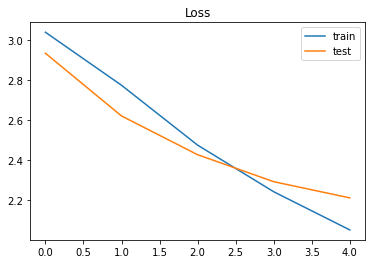

In [108]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

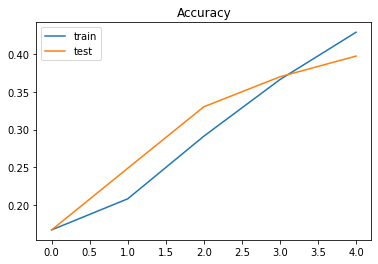

In [109]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Test with new tweets

Here a dataset with 200 tweets from one of the accounts analyzed in phase 2 are loaded.

In [110]:
dftest = pd.read_csv('/content/drive/My Drive/VIU/TFM/2nd Iteration/tweets_test1.csv', error_bad_lines=False, header=0)

In [111]:
dftest.iloc[1][1]

'weep make less depth grief'

In [112]:
[dftest.iloc[1][1]]

['weep make less depth grief']

In [113]:
dftest['text ready'] = dftest['text clean'].apply(lambda x: [x])

In [114]:
dftest

,text,text clean,text ready
0,"Change is the constant, the signal for rebirth...",change constant signal rebirth egg phoenix,[change constant signal rebirth egg phoenix]
1,To weep is to make less the depth of grief. - ...,weep make less depth grief,[weep make less depth grief]
2,"As long as one keeps searching, the answers co...",long one keeps searching answers come,[long one keeps searching answers come]
3,The greatest evil that can befall man is that ...,greatest evil befall man come think ill,[greatest evil befall man come think ill]
4,An open ear is the only believable sign of an ...,open ear believable sign open heart,[open ear believable sign open heart]
...,...,...,...
195,"Patience, persistence and perspiration make an...",patience persistence perspiration make unbeata...,[patience persistence perspiration make unbeat...
196,Self-trust is the first secret of success. - R...,selftrust first secret success,[selftrust first secret success]
197,Leap and the net will appear. - Julia Cameron,0,[0]
198,If you think you are too small to be effective...,think small effective never dark mosquito,[think small effective never dark mosquito]


In [119]:
labels = ['compassion', 'courage', 'creativity', 'death', 'faith', 'fear',
       'freedom', 'funny', 'god', 'good', 'grief', 'happiness', 'hope',
       'humor', 'imagination', 'inspirational', 'leadership', 'life', 'love',
       'motivational', 'pain', 'passion', 'peace', 'philosophy', 'purpose',
       'romance', 'success', 'truth', 'wisdom', 'work']


def predictor(text):
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(seq, maxlen=30)
    pred = model.predict(padded)
    return labels[np.argmax(pred)]

In [120]:
dftest['results']=3

In [121]:
dftest.results = dftest['text ready'].apply(lambda x: predictor(x))

In [122]:
dftest[:50]

,text,text clean,text ready,results
0,"Change is the constant, the signal for rebirth...",change constant signal rebirth egg phoenix,[change constant signal rebirth egg phoenix],humor
1,To weep is to make less the depth of grief. - ...,weep make less depth grief,[weep make less depth grief],pain
2,"As long as one keeps searching, the answers co...",long one keeps searching answers come,[long one keeps searching answers come],love
3,The greatest evil that can befall man is that ...,greatest evil befall man come think ill,[greatest evil befall man come think ill],love
4,An open ear is the only believable sign of an ...,open ear believable sign open heart,[open ear believable sign open heart],love
5,"When I let go of what I am, I become what I mi...",0,[0],love
6,"Whatever you can do or dream you can, begin it...",whatever dream begin boldness genius power magic,[whatever dream begin boldness genius power ma...,inspirational
7,Everything that irritates us about others can ...,everything irritates us others lead us underst...,[everything irritates us others lead us unders...,inspirational
8,"They say that time changes things, but you act...",say time changes things actually change,[say time changes things actually change],life
9,"Just remember, when you think all is lost, the...",remember think lost future remains,[remember think lost future remains],life


In [130]:
dftest['text'].iloc[33]

'Doing the best at this moment puts you in the baest place for the next moment. - Oprah Winfrey'

In [132]:
predictor(dftest['text ready'].iloc[33])

'life'

## Test with moods

In [125]:
mood1 = 'I feel kind of down because my boss did not respected my opinion in front of the others'
mood2 = 'My girlfriend ridiculed me'
mood3 = 'My father did not show me how to defend myself and now I have insecurities'
mood4 = 'I felt attacked by that cassier in the supermarket'
moods = [mood1, mood2, mood3, mood4]

In [126]:
def checktweet(tweet):
  # remove hyperlinks
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)

  # remove hashtags with space before it
  tweet = re.sub(r'(\s)#\w+', r'', tweet)
 
  # remove hashtags without space before it
  tweet = re.sub(r'#\w+', r'', tweet)
  
  # remove mentions
  tweet = re.sub(r'(\s)@\w+', '', tweet)
  
  # remove author
  if len([pos for pos, char in enumerate(tweet) if char == '-']) > 0:
    tweet = tweet[:[pos for pos, char in enumerate(tweet) if char == '-'][-1]]


  # remove punctuations and convert characters to lower case
  tweet = "".join([char.lower() for char in tweet if char not in string.punctuation]) 

  # Also, removes leading and trailing whitespaces
  tweet = re.sub('\s+', ' ', tweet).strip()
  
  # remove stop words
  tweet = " ".join([word for word in tweet.split() if word not in stopwords.words('english')]) 


  if (len(tweet) > 280) or (len(tweet) < 20):
    return 0
  else:  
    return tweet

In [127]:
temporal = [checktweet(mood3)]
temporal

['father show defend insecurities']

In [128]:
predictor(temporal)

'love'

In [129]:
for mood in moods:
    print(predictor([checktweet(mood)]))

inspirational
love
love
humor
